In [1]:
import sys
sys.path.append("../")
import numpy as np
import scipy.io as sio
import scipy.linalg as slinalg
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d as gf1d
import matplotlib.pyplot as plt
import ICP
import importlib
from PDE2D import *
import Mahalanobis
from SyntheticExamples import FlatTorusIdeal
from Kuramoto import *
from ripser import ripser
from persim import plot_diagrams as plot_dgms
from mpl_toolkits.mplot3d import Axes3D

# Sampling Rotated Patches / Computing Mahalanobis Diffusion Maps

In the first part of this demo, we sample a bunch of random square patches from a quasiperiodic regime of the KS solution which are randomly rotated.  We then use masked Mahalanobis diffusion maps to reconstruct the resulting torus attractor.  We use persistent homology to autotune the mask for Mahalanobis distance.

(220, 140)


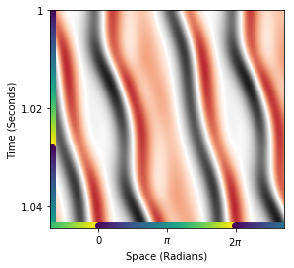

In [2]:
## First setup the solution grid of the Kuramoto Sivashinsky equation
np.random.seed(1)
fac = 0.5
ks = KSSimulation(co_rotating=False, scale=(fac*10, fac/1.42), reldir='../')
ks.crop(0, 220, 0, ks.I.shape[1])
print(ks.I.shape)
ks.drawSolutionImage()

In [3]:
## Sample observations
pd = (50, 50)
nsamples = 5000
pca_dim = 120 
f_patch = lambda patches: get_ftm2d_polar(patches, pd)
ks.makeObservations(pd, nsamples, rotate=True, uniform=True, f_patch=f_patch)
# Do PCA on the patch descriptors so Mahalanobis calculations are faster
ks.compose_with_dimreduction(dim=pca_dim)

Making 5000 rotated observations of dimension (50, 50) on a grid of (220, 140)...
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
Elapsed time patch sampling: 6.23
Reducing patch dimensions from 1024 to 120


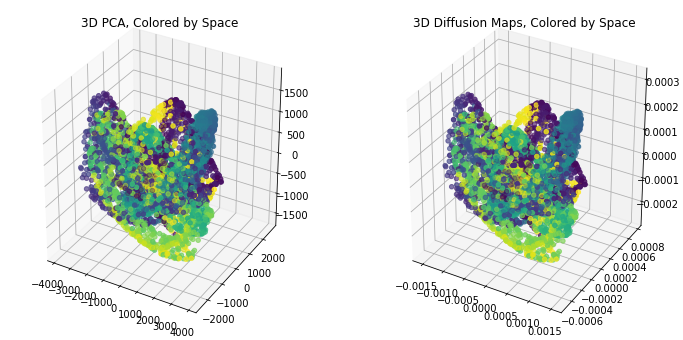

In [4]:
## Demonstrate how bad PCA and diffusion maps are by themselves without Mahalanobis

# Do PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
YPCA = pca.fit_transform(ks.patches)

# Do diffusion maps
DSqr = getSSM(ks.patches)**2
eps = np.max(DSqr)
YDMaps = getDiffusionMap(DSqr, eps=eps, distance_matrix=True, neigs=4)

xcoords = ks.xcoords
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(YPCA[:, 0], YPCA[:, 1], YPCA[:, 2], c=xcoords)
ax.set_title("3D PCA, Colored by Space")
ax = fig.add_subplot(122, projection='3d')
ax.scatter(YDMaps[:, 0], YDMaps[:, 1], YDMaps[:, 2], c=xcoords)
ax.set_title("3D Diffusion Maps, Colored by Space")
plt.show()

In [5]:
## Compute the Mahalanobis distance and mask indices
delta = 5
n_points = 100
rank = 2
maxeigs = 100
dMaxSqr = 1000
ellipsoid_fn = lambda idx, delta, n_points: ks.get_mahalanobis_ellipsoid(idx, delta, n_points, uniform_circle=True)
res = Mahalanobis.getMahalanobisDists(ks.patches, ellipsoid_fn, delta, n_points=n_points, rank=rank, maxeigs=maxeigs)
gamma, maskidx = res["gamma"], res["maskidx"]

Computing Jacobians, rank = 2, maxiegs = 100...
0 of 5000
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
Elapsed Time: 738
Computing Mahalanobis Distances...
Elapsed Time: 107


In [6]:
## Compute diffusion maps and TDA at all thresholds of the mask
eps = dMaxSqr*np.max(gamma)*1e-3 # Autotune diffusion eps in terms of point cloud diameter
# Try different thresholds of the Mahalanobis mask
res = getMahalanobisAllThresh(gamma, maskidx, eps=eps, neigs=8, verbose=True)
alldgms = res["alldgms"]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Elapsed Time: 1.13e+03


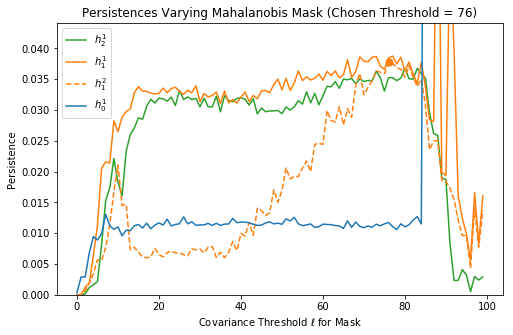

In [7]:
## Plot the persistences of H0, H1, and H2
plt.figure(figsize=(8, 5))
scores = getTorusPersistenceScores(alldgms, do_plot=True)["scores"]
plt.savefig("TorusScores.svg", bbox_inches='tight')

In [8]:
## Redo diffusion maps computation and persistence diagrams at the chosen threshold
## for demonstration 
thresh = np.argmax(scores)
mask = np.array(maskidx >= thresh, dtype=float)
Y = getDiffusionMap(gamma, eps=eps, distance_matrix=True, mask=mask, neigs=8)
dgms = ripser(Y, n_perm=400, maxdim=2)['dgms']

In [9]:
## Do a rudimentary estimate of torus coordinates using the arctangent
## of the first two dmaps coordinates and the second two dmaps coordinates
## (we will refine this later with diffusion maps)
theta = np.arctan2(Y[:, 1], Y[:, 0])
phi = np.arctan2(Y[:, 3], Y[:, 2])

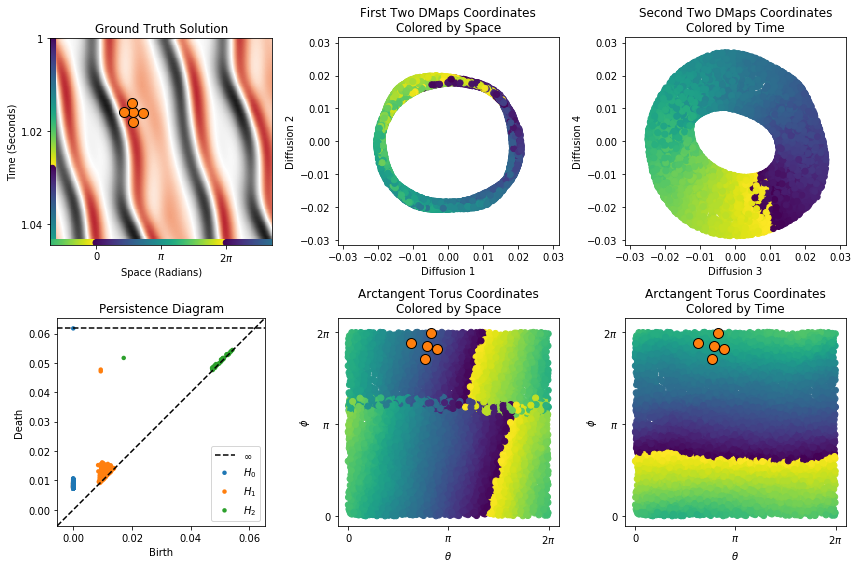

In [10]:
## Plot the diffusion maps results alongside the persistence diagram

# Pick an example point to show the stencil
dstencil = 10
poss = np.array([[0, 0], [-dstencil, 0], [dstencil, 0], [0, -dstencil], [0, dstencil]])
xpos = poss[:, 0] + 40
tpos = poss[:, 1] + 80
idx = np.argmin(np.abs(ks.Xs[:, None]-xpos[None, :])+np.abs(ks.Ts[:, None]-tpos[None, :]), axis=0)
c = 'C1'

sz = np.max(np.abs(Y[:, 0:4]))*1.1
plt.figure(figsize=(12, 8))
plt.subplot(231)
ks.drawSolutionImage()
plt.title("Ground Truth Solution")
plt.scatter(ks.Xs[idx], ks.Ts[idx], 100, c=c, edgecolors='k')
plt.subplot(232)
plt.scatter(Y[:, 0], Y[:, 1], c=ks.xcoords, cmap='viridis')
plt.xlabel("Diffusion 1")
plt.ylabel("Diffusion 2")
plt.xlim([-sz, sz])
plt.ylim([-sz, sz])
#plt.axis('equal')
plt.title("First Two DMaps Coordinates\nColored by Space")
plt.subplot(233)
plt.xlabel("Diffusion 3")
plt.ylabel("Diffusion 4")
plt.xlim([-sz, sz])
plt.ylim([-sz, sz])
#plt.axis('equal')
plt.title("Second Two DMaps Coordinates\nColored by Time")
plt.scatter(Y[:, 2], Y[:, 3], c=ks.tcoords, cmap='viridis')

plt.subplot(235)
plt.scatter(theta, phi, c=ks.xcoords, cmap='viridis')
plt.scatter(theta[idx], phi[idx], 100, c=c, edgecolors='k')
plt.xlabel("$\\theta$")
plt.ylabel("$\\phi$")
plt.xticks([-np.pi, 0, np.pi], ["0", "$\\pi$", "$2 \\pi$"])
plt.yticks([-np.pi, 0, np.pi], ["0", "$\\pi$", "$2 \\pi$"])
plt.title("Arctangent Torus Coordinates\nColored by Space")

plt.subplot(236)
plt.scatter(theta, phi, c=ks.tcoords, cmap='viridis')
plt.scatter(theta[idx], phi[idx], 100, c=c, edgecolors='k')
plt.xlabel("$\\theta$")
plt.ylabel("$\\phi$")
plt.xticks([-np.pi, 0, np.pi], ["0", "$\\pi$", "$2 \\pi$"])
plt.yticks([-np.pi, 0, np.pi], ["0", "$\\pi$", "$2 \\pi$"])
plt.title("Arctangent Torus Coordinates\nColored by Time")
plt.subplot(234)
plot_dgms(dgms)
plt.title("Persistence Diagram")

plt.tight_layout()
plt.savefig("DMapsArctan.svg", bbox_inches='tight')

# Flattening Torus via ICP To Template

rmse=0.19
rmse=0.17
rmse=0.189
rmse=0.189
rmse=0.17
rmse=0.193
rmse=0.17
rmse=0.19
rmse=0.193
rmse=0.19
rmse=0.17
rmse=0.17
rmse=0.178
rmse=0.17
rmse=0.17
rmse=0.17
rmse=0.189
rmse=0.17
rmse=0.17
rmse=0.17


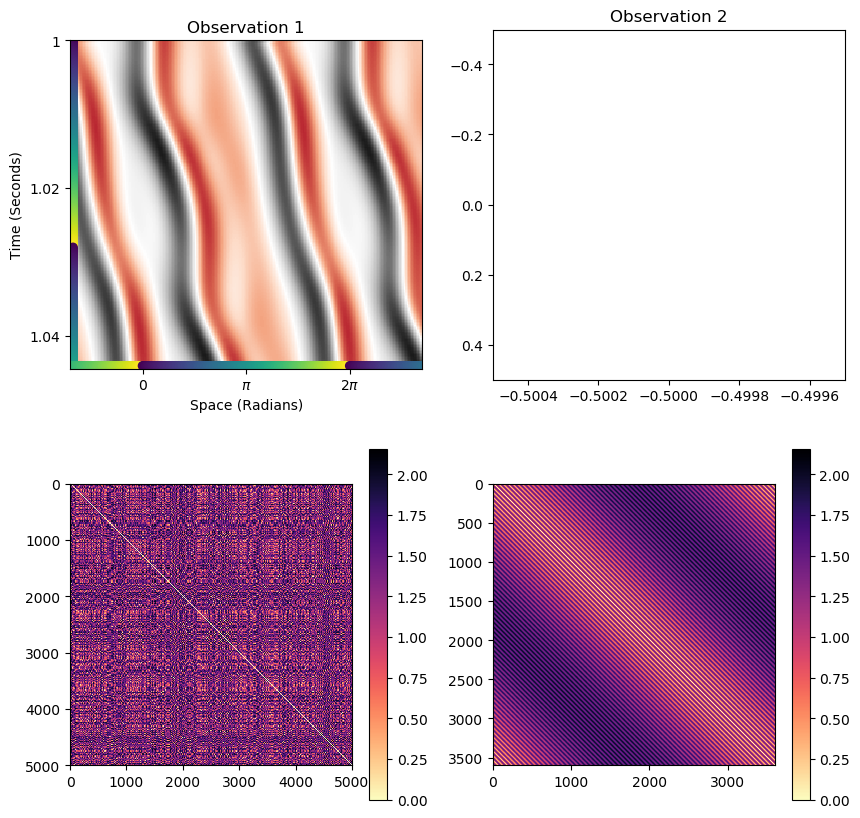

In [11]:
## Align to an ideal flat torus
from SyntheticExamples import FlatTorusIdeal
importlib.reload(ICP)
ft = FlatTorusIdeal(60, 60, Y.shape[1])
Yft = ft.Y
res = ICP.doICP_PDE2D(ks, Y[:, 0:4], ft, Yft[:, 0:4], initial_guesses=20, do_plot=False)
idxMin, rmses_iter = res['idxMin'], res['rmses_iter']

In [12]:
## Resample the centers of each patch for plotting purposes
ks.f_patch = lambda x: x
ks.completeObservations()
f_interp = ks.getInterpolator()
patch_centers = f_interp(ks.Ts.flatten(), ks.Xs.flatten(), grid=False)
vmax = np.max(np.abs(ks.I))
vmin = -vmax

Elapsed time patch sampling: 3.09


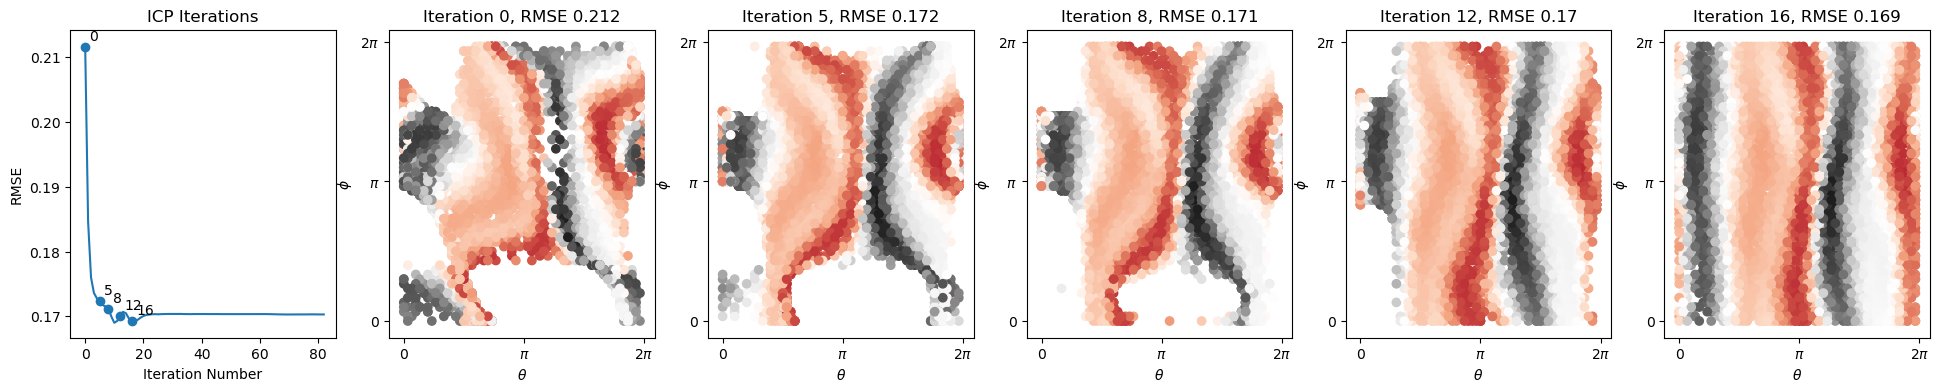

In [18]:
## Plot the result at different iterations of ICP
snapshots = [0, 5, 8, 12, 16]
snapshots = [min(s, len(rmses_iter)-1), for s in snapshots]
res = 4
nsub = len(snapshots)+1
plt.figure(figsize=(res*nsub, res))
plt.subplot(1, nsub, 1)
plt.plot(rmses_iter)
plt.scatter(snapshots, rmses_iter[snapshots])
for s in snapshots:
    plt.text(s+1.5, rmses_iter[s]+0.001, "%i"%s)
plt.xlabel("Iteration Number")
plt.ylabel("RMSE")
plt.title("ICP Iterations")
for i, idx in enumerate(snapshots):
    # Plot the locations of each patch based on the
    # positions of the corresponding indices on the flat torus
    plt.subplot(1, nsub, i+2)
    Ts = ft.Ts[idxMin[idx]]
    Xs = ft.Xs[idxMin[idx]]
    plt.scatter(Xs, Ts, c=patch_centers, cmap='RdGy', vmin=vmin, vmax=vmax)
    plt.xticks([0, 0.5, 1], ["0", "$\\pi$", "$2 \\pi$"])
    plt.yticks([0, 0.5, 1], ["0", "$\\pi$", "$2 \\pi$"])
    plt.xlabel("$\\theta$")
    plt.ylabel("$\\phi$")
    plt.title("Iteration %i, RMSE %.3g"%(idx, rmses_iter[idx]))
plt.savefig("ICPIters.svg", bbox_inches='tight')

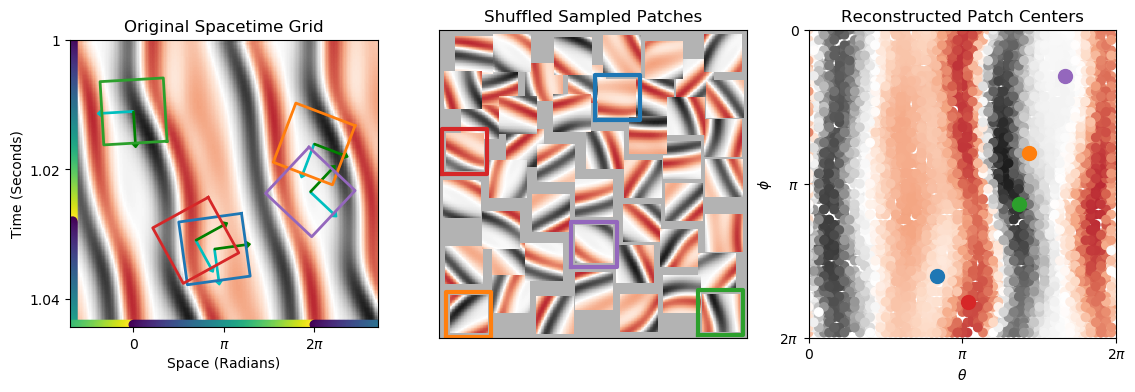

In [14]:
import matplotlib.transforms as mtransforms


NToPlot = 5
plt.figure(figsize=(9*1.5, 4))

I = ks.I
for seed in range(20):
    plt.clf()
    x = np.array([ks.Xs, ks.Ts]).T
    #idxs, _ = getGreedyPerm(x)
    np.random.seed(seed)
    idxs = np.random.permutation(x.shape[0])

    plt.subplot(131)
    ks.drawSolutionImage()
    for i in range(NToPlot):
        ks.plotPatchBoundary(idxs[i], color='C%i'%i, sz=2)
    plt.title("Original Spacetime Grid")

    plt.subplot(132)
    ax = plt.gca()

    N = 49
    locs = np.random.rand(N*100, 2)
    idx, _ = getGreedyPerm(locs, N)
    locs = locs[idx, :]
    idx = idx[np.random.permutation(N)]

    sz = 0.5/np.sqrt(N)
    box = 1.2*np.array([[-sz, -sz], [-sz, sz], [sz, sz], [sz, -sz], [-sz, -sz]])

    toplot = list(range(N))
    toplot.reverse()
    for i in toplot:
        p = np.reshape(ks.patches[idxs[i], :], ks.pd)
        im = ax.imshow(p, interpolation='none', extent=(-sz, sz, -sz, sz), alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
        m = np.eye(3)
        u = locs[i, :]
        m[0:2, 2] = u
        trans = mtransforms.Affine2D()
        trans.set_matrix(m)
        im.set_transform(trans + ax.transData)
        if i < NToPlot:
            plt.plot(box[:, 0] + u[0], box[:, 1] + u[1], c='C%i'%i, lineWidth=3)
    sz *= 1.2
    plt.xlim([-sz, 1+sz])
    plt.ylim([-sz, 1+sz])
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    c = 0.7
    ax.set_facecolor((c, c, c))
    plt.title("Shuffled Sampled Patches")

    plt.subplot(133)
    XsSol = ft.Xs[idxMin[-1]]*2*np.pi #+ 0.1*np.random.randn(XsSol.size)
    TsSol = ft.Ts[idxMin[-1]]*2*np.pi #+ 0.1*np.random.randn(TsSol.size)
    plt.scatter(XsSol, TsSol, c=patch_centers, cmap='RdGy', vmin=vmin, vmax=vmax)
    for i in range(NToPlot):
        plt.scatter(XsSol[idxs[i]], TsSol[idxs[i]], 100, c='C%i'%i)
    plt.xticks([0, np.pi, 2*np.pi], ["0", "$\\pi$", "$2 \\pi$"])
    plt.yticks([0, np.pi, 2*np.pi], ["0", "$\\pi$", "$2 \\pi$"])
    plt.xlim([0, 2*np.pi])
    plt.ylim([0, 2*np.pi])
    plt.gca().invert_yaxis()
    plt.title("Reconstructed Patch Centers")
    plt.xlabel("$\\theta$")
    plt.ylabel("$\\phi$")

    plt.savefig("RotatedPatches%i.svg"%seed, bbox_inches='tight')

# Uncovering Rotations

We now use Fourier methods and the connection Laplacian to uncover the global orientations of all patches, up to a constant offset, and we plot information 

Elapsed time patch sampling: 3.13
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 Doing connection Laplacian...
[0.99392045 0.99379224]
500 of 800


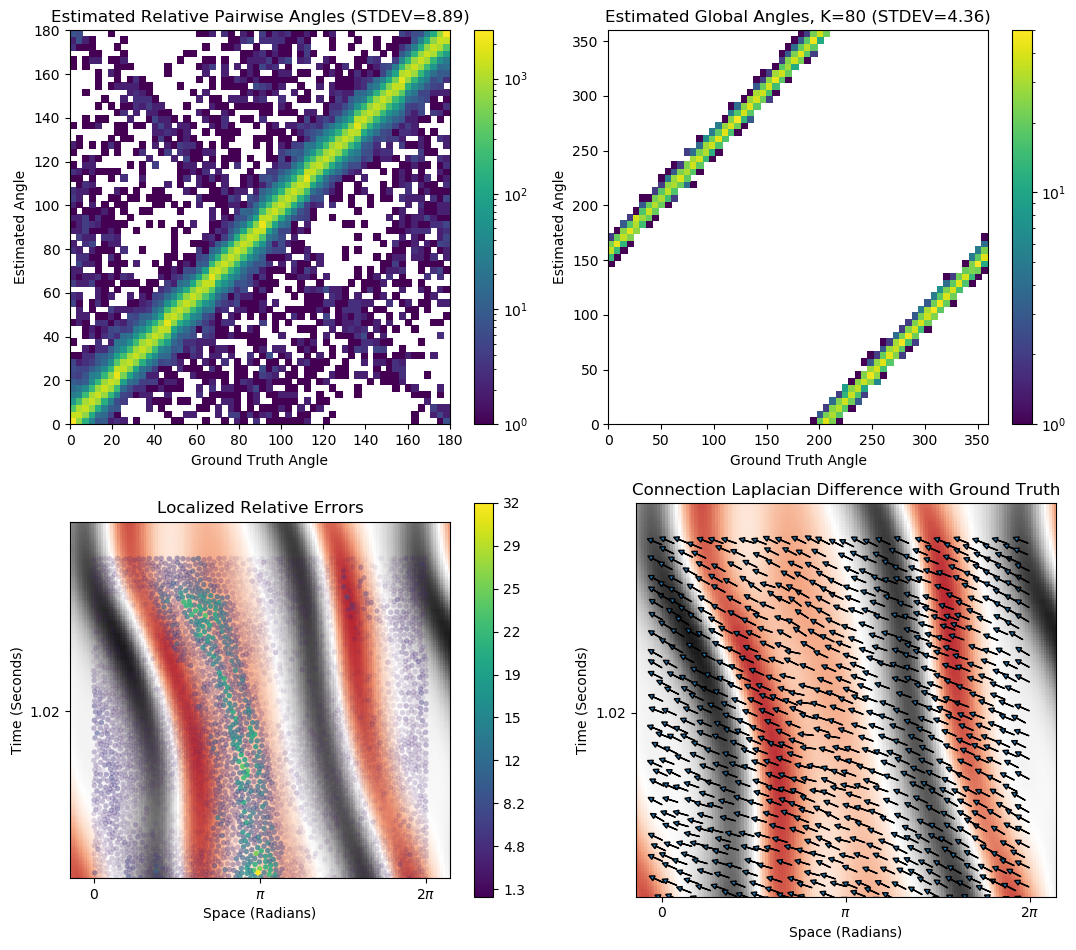

In [15]:
## Recover all of the global rotations, using
## different numbers of neighbors and weighted/unweighted versions
## of the connection Laplacian
from matplotlib.colors import LogNorm
bins=60

fac = 0.8
plt.figure(figsize=(fac*14, fac*12))

K = 80
corrweight = False

res = ks.estimate_rotations(Y, K)
thetas_est, thetasij, ws = res['thetas_est'], res['thetasij'], res['ws']
thetas_est = np.mod(thetas_est, 2*np.pi)
diff = ks.thetas - thetas_est
diff -= np.median(diff)
diff = np.arctan2(np.sin(diff), np.cos(diff))
I = np.array(thetasij[:, 0], dtype=int)
J = np.array(thetasij[:, 1], dtype=int)


thetasijest = np.abs(thetasij[:, 2])
thetasijest = np.minimum(thetasijest, 2*np.pi-thetasijest)
thetasijgt = np.abs(ks.thetas[I] - ks.thetas[J])
thetasijgt = np.minimum(thetasijgt, 2*np.pi-thetasijgt)
thetasij[:, 2] = np.mod(thetasij[:, 2], 2*np.pi)

diffrel = thetasijest - thetasijgt

plt.clf()
plt.subplot(222)
x = ks.thetas*180/np.pi
y = thetas_est*180/np.pi
counts,ybins,xbins,image = plt.hist2d(x, y,bins=bins,norm=LogNorm())
plt.colorbar()
#sns.kdeplot(x, y)
#plt.scatter(x, y, 2, marker='x')
plt.xlabel("Ground Truth Angle")
plt.ylabel("Estimated Angle")
plt.title("Estimated Global Angles, K=%i (STDEV=%.3g)"%(K, np.std(180*diff/np.pi)))
plt.xlim([0, 360])
plt.ylim([0, 360])

plt.subplot(221)
x = thetasijest*180/np.pi
y = thetasijgt*180/np.pi
counts,ybins,xbins,image = plt.hist2d(x, y,bins=bins,norm=LogNorm())
plt.colorbar()
#sns.kdeplot(x, y)
#plt.scatter(x, y, 2, marker='x')
plt.xlabel("Ground Truth Angle")
plt.ylabel("Estimated Angle")
plt.title("Estimated Relative Pairwise Angles (STDEV=%.3g)"%np.std(180*diffrel/np.pi))

plt.subplot(224)
ks.drawSolutionImage()
ks.plotEstimatedRotations(thetas_est, 800)
plt.xlim([-10, ks.I.shape[1]+10])
plt.ylim([ks.I.shape[0]-50, 20])
plt.title("Connection Laplacian Difference with Ground Truth")

plt.subplot(223)
ks.drawSolutionImage()
ks.plotRelativeRotationErrors(thetasij)

plt.xlim([-10, ks.I.shape[1]+10])
plt.ylim([ks.I.shape[0]-50, 20])
plt.title("Localized Relative Errors")

plt.tight_layout()
plt.savefig("EstimatedAngle_%i_corr%i.png"%(K, corrweight), bbox_inches='tight')